In [5]:
import os
import tifffile
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tqdm


In [6]:

generated_folder = "../gen-cloudless/out/DSen2-CR_001/predictions/"
pristine_folder = "../gen-cloudless/data/ROIs1868_summer_s2/"
cloudy_folder = "../gen-cloudless/data/ROIs1868_summer_s2_cloudy/"

base = "ROIs1868_summer"
pristine_prefix = "s2"
cloudy_prefix = "s2_cloudy"

In [7]:
def get_generated_file_ids():
    # get all files in the dirs
    files = []
    for id in os.listdir(generated_folder):
        if id.endswith(".tif"):
            files.append(id)
            
    files = set(files)
    return list(files)

def _batch_normalization(tensor_in, epsilon=.0001):
    mean,variance = tf.nn.moments(tensor_in,axes=[0])
    print(mean)
    tensor_normalized = (tensor_in-mean)/(variance+epsilon)
    return tensor_normalized * 2000
    
def get_data():
    files = get_generated_file_ids()
    
    generated_imgs = []
    for id in tqdm.tqdm(files):
        img = tifffile.imread(os.path.join(generated_folder, id), )
        img = img[:13].transpose(2,1,0)[32:32+64, 32:32+64, :]
        generated_imgs.append(img)
    generated_imgs = np.array(generated_imgs, dtype=np.float32)
    generated_imgs_tf = tf.data.Dataset.from_tensor_slices(generated_imgs).map(lambda x: x * 2000)
    # print(generated_imgs.shape)

    pristine_imgs = []
    for id in tqdm.tqdm(files):
        main_id = id.split("_")[0]
        path = os.path.join(pristine_folder, f'{pristine_prefix}_{main_id}', f'{base}_{pristine_prefix}_{id}')
        img = tifffile.imread(path)[96:96+64, 96:96+64, :]
        pristine_imgs.append(img)
    pristine_imgs = np.array(pristine_imgs, dtype=np.float32)
    pristine_imgs_tf = tf.data.Dataset.from_tensor_slices(pristine_imgs)
    # print(pristine_imgs.shape)

    cloudy_imgs =[]
    for id in tqdm.tqdm(files):
        main_id = id.split("_")[0]
        path = os.path.join(cloudy_folder, f'{cloudy_prefix}_{main_id}', f'{base}_{cloudy_prefix}_{id}')
        img = tifffile.imread(path)[96:96+64, 96:96+64, :]
        cloudy_imgs.append(img)
    cloudy_imgs = np.array(cloudy_imgs, dtype=np.float32)
    cloudy_imgs_tf = tf.data.Dataset.from_tensor_slices(cloudy_imgs)
    # print(cloudy_imgs.shape)
    
    return generated_imgs_tf, pristine_imgs_tf, cloudy_imgs_tf

### Do predictions on the generated, cloudy and pristine images
Remember we take the prediction of the pristine image as the "ground truth"

In [8]:
cloudless_imgs_tf, pristine_imgs_tf, cloudy_imgs_tf = get_data()

100%|██████████| 3376/3376 [00:43<00:00, 78.16it/s] 


In [9]:
cloudy_imgs_tf.element_spec

TensorSpec(shape=(64, 64, 13), dtype=tf.float32, name=None)

### Load existing ResNet-50 model


In [10]:
model = keras.models.load_model("./resnet-50/resnet50_eurosat_model_lr_2")


In [11]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 13)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 13)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   40832       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']      

In [44]:
def get_predictions_for_set(tfset: tf.data.Dataset):
    preds = []
    tfset = tfset.batch(5)
    for batch in tqdm.tqdm(tfset):
        preds.extend(np.argmax(model.predict(batch), axis=1))
    return np.array(preds)

ground_truth = get_predictions_for_set(pristine_imgs_tf)
baseline = get_predictions_for_set(cloudy_imgs_tf)
cloudless = get_predictions_for_set(cloudless_imgs_tf)

100%|██████████| 676/676 [00:28<00:00, 23.94it/s]


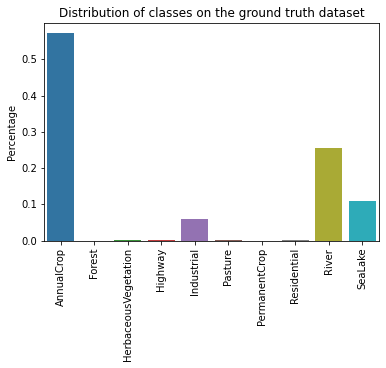

In [60]:
# Plot distributionplot of predictions
classmap = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway',
            4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

def histplot_for_dataset(title, dataset):
    mapped = {v: 0 for k,v in classmap.items()}
    for d in dataset:
        mapped[classmap[d]] += 1

    total = sum(mapped.values())
    mapped = {k: v/total for k,v in mapped.items()}

    plt.xticks(rotation='vertical')
    plt.ylabel("Percentage")
    plt.title(title)
    sns.barplot(x=list(mapped.keys()), y=list(mapped.values()))
    plt.savefig(f"{title}.pdf",  bbox_inches="tight")

histplot_for_dataset("Distribution of classes on the ground truth dataset", ground_truth)


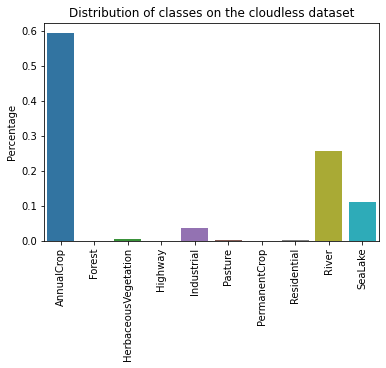

In [62]:
histplot_for_dataset("Distribution of classes on the cloudless dataset", cloudless)


In [ ]:
eurosat_data, info = tfds.load('eurosat/all', as_supervised=True, with_info=True)
eurosat_data = eurosat_data['train']
eurosat_data_y = tfds.as_numpy(eurosat_data.map(lambda x, y: y))
eurosat_data_x = eurosat_data.map(lambda x, y: x)


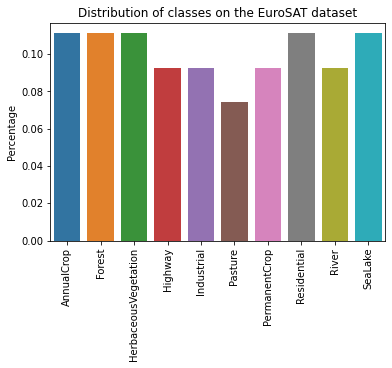

In [61]:
histplot_for_dataset("Distribution of classes on the EuroSAT dataset", eurosat_data_y)

Ground truth, baseline: 0.398696682464455
Ground truth, cloudless: 0.7565165876777251


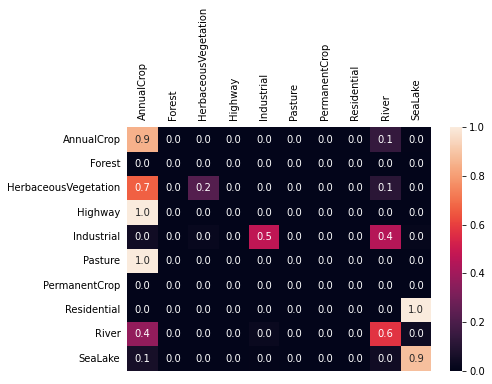

In [59]:
print('Ground truth, baseline:', metrics.accuracy_score(ground_truth, baseline))
print('Ground truth, cloudless:', metrics.accuracy_score(ground_truth, cloudless))

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)
plt.tight_layout()
sns.heatmap(metrics.confusion_matrix(ground_truth, cloudless, normalize='true', labels=np.arange(0, 10)), annot=True, fmt='.1f', xticklabels=classmap.values(), yticklabels=classmap.values())
plt.savefig('confusion_matrix_cloudless.pdf', bbox_inches="tight")